# NEURON Exercise: Stochastic synapse dynamics

Copyright © 2005-2021 Blue Brain Project/EPFL. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Introduction

In this graded exercise we will get an in-depth view of the stochastic Tsodyks-Markram Model for synaptic transmission, implement a multi-synapse connection and quantify advanced aspects of its _simulated_ electrophysiology. 

**Important**: Ensure you have downloaded the MOD files, and compiled them with NMODL in Week 4 Exercise 1.  It is only necessary to do this once for all Week 4 exercises. 
 

## Initialize NEURON

In [1]:
import neuron
from neuron import h
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

## A neuron to host your synapse

Following previous exercises, we will create a single compartment soma neuron to host the synapses.

In [2]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

__nrnsec_0x1b57f70

In [3]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

Create 10 synapses at the center of the soma compartment

In [4]:
synapse_list = []
rng_list = []
num_synapses = 10
for i in range(num_synapses):
    synapse = h.StochasticTsodyksMarkram_AMPA_NMDA(soma(0.5))
    rng = h.Random()                                                          
    rng.Random123(1)  # configure the random number generator (rng) type, and the "seed" (more on that below)                     
    rng.uniform(0,1)  # configure the rng to emit uniformly distributed random numbers between 0 and 1
                      # as required by the synapse MOD file.
    synapse.setRNG(rng)
    synapse_list.append(synapse)
    rng_list.append(rng)

Define the stimulus: 8 spikes at 20Hz + 1 spike 500 ms later

In [5]:
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]

In [6]:
conn_list = []
stimulator = h.VecStim()
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

for synapse in synapse_list:
    connection = h.NetCon(stimulator, synapse)
    connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
    conn_list.append(connection)

Create a recorder for the synaptic conductance, current, the soma voltage, the time intervals, and Use and R

In [7]:
g_syn_list = []
Use_syn_list = []
R_syn_list = []
for synapse in synapse_list:
    g_syn = h.Vector()
    g_syn.record(synapse._ref_g)
    g_syn_list.append(g_syn)
    Use_syn = h.Vector()
    Use_syn.record(synapse._ref_Use)
    Use_syn_list.append(Use_syn)
    R_syn = h.Vector()
    R_syn.record(synapse._ref_R)
    R_syn_list.append(R_syn)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

Vector[32]

Let's configure biologically plausible parameters for the AMPA and NMDA receptors, and parameters for depressing synapse (E2) dynamics.

In [8]:
for synapse in synapse_list:
    synapse.gmax_AMPA = 0.001 # uS
    synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
    synapse.mg = 1.0 # mM
    synapse.U1 = 0.5 # Baseline release probability
    synapse.tau_rec = 700 # ms - recovery from depression
    synapse.tau_facil = 10 # ms - relaxation from facilitation

Now let's simulate

In [9]:
h.tstop = 1000.0 # ms
neuron.h.run()

0.0

(0.0, 1000.0, -70.0, -60.0)

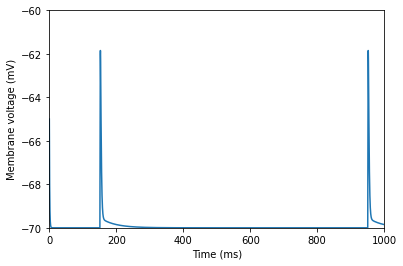

In [10]:
def plot_timecourse(time_array, dependent_var, newfigure=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
        
plot_timecourse(time, v_soma)
plt.axis([0, 1000, -70, -60])

Hmmm. Something strange is going on here!  We have only 2 of the 9 expected PSPs, they're very strong and there's no depression!  Let's look closer at the conductance trace of each synapse, to see if it provides a clue.  Let's use a 3d plot to get a better view of each trace.  

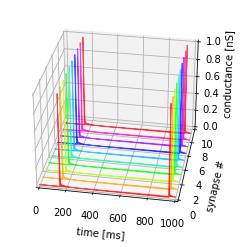

In [11]:
def plot_synapse_traces():
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.collections import PolyCollection
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')

    # use the hsv colormap (https://matplotlib.org/users/colormaps.html)
    colormap = plt.get_cmap("hsv")

    verts = []
    for i, g_syn in enumerate(g_syn_list):
        verts.append(list(zip(time, 1000.*numpy.array(g_syn))))

    # produce 10 different colors with 60% transparency (alpha) using
    # list comprehension (https://docs.python.org/2/tutorial/datastructures.html#list-comprehensions)
    facecolors = [colormap(x, alpha=0.6) for x in numpy.linspace(0,1,10)]
    poly = PolyCollection(verts, facecolors=facecolors, edgecolors=facecolors)
    poly.set_alpha(0.7)
    ax.add_collection3d(poly, zs=range(num_synapses), zdir='y')

    ax.set_xlabel('time [ms]')
    ax.set_xlim3d(0, 1000)
    ax.set_zlabel('conductance [nS]')
    ax.set_zlim3d(0, 1.)
    ax.set_ylabel('synapse #')
    ax.set_ylim3d(0, num_synapses)
    ax.view_init(30, -80)

plot_synapse_traces()

The synapses are intended to be stochastic, but each synapse is doing the exact same thing!  We made an important conceptual error above when configuring our random number generators.  Can you spot it?  Random number generators generate pseudo-random streams of numbers which are reproducible for a given **seed**. We initialized the rngs for each of our ten synapses with the _same_ seed.  Let's give the rng associated with each synapse a different seed, so that each synapse will receive an independent rng stream. 

In [12]:
for i in range(len(rng_list)):
    rng_list[i].Random123(i) # seed each rng with its index in the rng_list
    rng_list[i].uniform(0,1)

In [13]:
h.tstop = 1000.0 # ms
neuron.h.run()

0.0

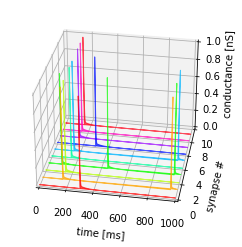

In [14]:
plot_synapse_traces()

Now that looks better!  Each synapse is doing its own thing (for the same input spike train) as they would if they were all participating in a typical **multi-synapse connection**.  Note that the peak conductance is always the same, but that synapses fail, i.e. they don't always respond to a pre-synaptic spike.  So then, how is this synapse expressing depression?  Let's look at the average g_syn and voltage trace ...

(0.0, 1000.0, -70.0, -60.0)

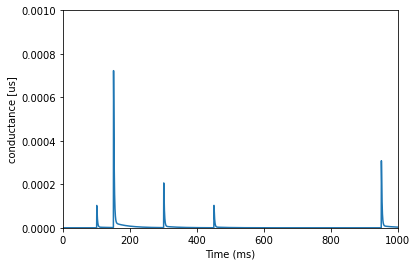

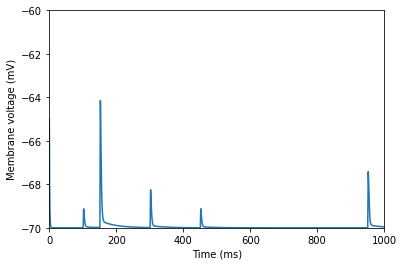

In [15]:
plot_timecourse(time, numpy.mean(g_syn_list, axis=0), ylabel="conductance [us]")
plt.axis([0, 1000, 0, 0.001])
plot_timecourse(time, v_soma)
plt.axis([0, 1000, -70, -60])

Indeed, the response appears to depress, but its hard to judge with only a single trial.  Let's run 100 simulations ... 

In [16]:
mean_gsyn_list = []
mean_Rsyn_list = []
mean_Usesyn_list = []
v_list = []
num_trials = 100
for i in range(num_trials):
    neuron.h.run()
    v_list.append(numpy.array(v_soma))
    mean_gsyn_list.append(numpy.mean(g_syn_list, axis=0))
    mean_Rsyn_list.append(numpy.mean(R_syn_list, axis=0))
    mean_Usesyn_list.append(numpy.mean(Use_syn_list, axis=0))


 ... and plot the mean and variability across _trials_.  

Text(0.5, 0, 'time [ms]')

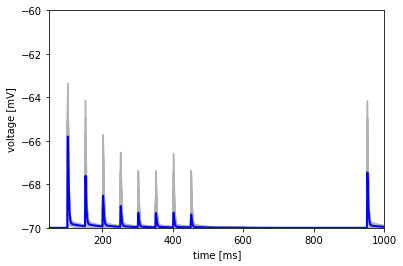

In [17]:
plt.figure()
for v in v_list:
    plt.plot(time, v, '-', color='0.7')
plt.plot(time, numpy.mean(v_list, axis=0), 'b-', lw=2)
plt.axis([50, 1000, -70, -60])
plt.ylabel("voltage [mV]")
plt.xlabel("time [ms]")

In [18]:
def extract_peaks(time, trace, event_times, window=10):
    """
    Computes the peak between event_times and returns the times of occurence and the maximums
    Useful for finding PSP or conductance peaks due to synaptic events.
    kwarg 'window' defines the time in ms after the event to consider when searching for the peak
    """
    
    peaks_list = []
    peaks_times_list = []
    for event_time in event_times:
        i_start = time.searchsorted(event_time)
        i_end = time.searchsorted(event_time+window)
        # find the index where the max occurs
        i_max = numpy.argmax(trace[i_start:i_end])
        # append the time and value at the max to the respective lists
        peaks_times_list.append(time[i_start:i_end][i_max])
        peaks_list.append(trace[i_start:i_end][i_max])
        
    return numpy.array(peaks_times_list), numpy.array(peaks_list)

In [19]:
peak_times, peaks = extract_peaks(numpy.array(time), numpy.mean(v_list, axis=0), spike_times)

Let's check the peaks are being extracted properly, by visual inspection ...
To this end, let's plot the peak locations as little red dots on top of the voltage traces.

Text(0.5, 0, 'time [ms]')

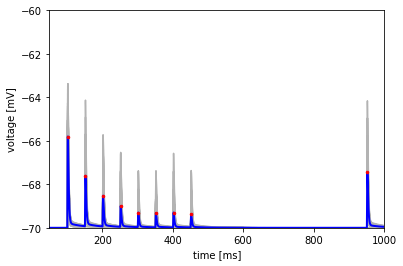

In [20]:
plt.figure()
for v in v_list:
    plt.plot(time, v, '-', color='0.7')
plt.plot(time, numpy.mean(v_list, axis=0), 'b-', lw=2)
plt.plot(peak_times, peaks, 'r.', ms=5)
plt.axis([50, 1000, -70, -60])
plt.ylabel("voltage [mV]")
plt.xlabel("time [ms]")

Let's plot the PSP distribution _across_ _trials_ of the 1st and 8th spikes

(array([51.,  0.,  0.,  0., 31.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
         1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
         2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
         3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
         4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
         5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
         6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
         7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
         8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
         9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10. 

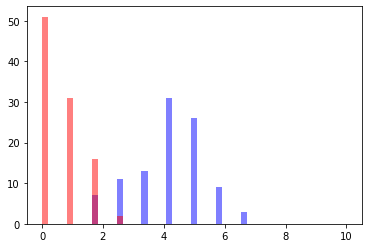

In [21]:
psps = []
for v in v_list:
    peak_times, peaks = extract_peaks(numpy.array(time), v, spike_times)
    psps.append(peaks)
# turn it into an array so we can take column slices, to compute the histograms
psps = numpy.vstack(psps) - numpy.min(v)
plt.figure()
bins = numpy.linspace(0., 10., 50)
plt.hist(psps[:,0], bins=bins, facecolor='blue', alpha=0.5, label="PSP dist of $1^\mathrm{st}$ spike")  # 1st spike is the 0th column
plt.hist(psps[:,7], bins=bins, facecolor='red', alpha=0.5, label="PSP dist of $8^\mathrm{th}$ spike")  # 1st spike is the 0th column

As can be seen by the lack of intermingling PSP amplitudes in the histogram, PSP amplitudes are quantized to 10 distinct non-zero values (equal to the number of synapses), and an eleventh bin around zero represents total failure of all synapses in this multi-synapse connection.  In fact, they are governed by a binomial distribution with n=10, and dynamic p (for the 1st PSP in the train, we have p = U1).

## Exercise Question 1

What is the coefficient of variation ([defined](https://en.wikipedia.org/wiki/Coefficient_of_variation) as the standard deviation / mean) of the 1st PSP in the train (across trials).  
Use numpy.mean, and numpy.std to compute the quantity.  Add your answer to the **ans** dictionary as a string or float with key "Q1".  

In [22]:
ans = {}
ans["Q1"] = "my answer"

## Exercise Question 2

What is the coefficient of variation ([defined](https://en.wikipedia.org/wiki/Coefficient_of_variation) as the standard deviation / mean) of the 1st PSP in the train (across trials). This time, use the mathematical expression for CV for a binomial distribution: $\sqrt{\frac{1-p}{np}}$.  Add your answer to the **ans** dictionary as a string or float with key "Q2".  

In [23]:
ans["Q2"] = "my answer"

## Failure rates

## Exercise Question 3

What is the failure rate of the 8th PSP in the train.  The failure rate is the fraction of trials for which no PSP is generated.  A good way to compute this might be to use numpy.histogram.  Add your answer to the **ans** dictionary as a string or float with key "Q3".  

In [24]:
ans["Q3"] = "my answer"

In [25]:
print(ans)

{'Q1': 'my answer', 'Q2': 'my answer', 'Q3': 'my answer'}


## Exercise Question 4

Analysing these simulations, what is the fraction of synapses in the recovered state after the 8th release event. Add your answer to the **ans** dictionary as a string or float with key "Q4".

In [26]:
ans["Q4"] = "my answer"

## Exercise Question 5

For the deterministic Tsodyks-Markram model, the peak AMPA conductance associated with a release event is modulated by R, the fraction of available vesicles.  While the stochastic Tsodyks-Markram model is more complicated, in this case it's simpler!  Assuming a single synapse releases at the 1st and at the 8th PSP, what is the ratio of the associated peak AMPA conductances of these two events? Add your answer to the **ans** dictionary as a string or float with key "Q5". 

In [27]:
ans["Q5"] = "my answer"

## Submit you answers
Print your **ans** dictionary as a json string, and submit the string to the course platform by executing the submission code below.  You will also need a submission key from the course platform. 

In [28]:
import json; print(json.dumps(ans))

{"Q1": "my answer", "Q2": "my answer", "Q3": "my answer", "Q4": "my answer", "Q5": "my answer"}


In [29]:
# Submit your answer.  The submission key can be retrieved from the edX platform
import single_cell_mooc_client as sc_mc
submission_widget = sc_mc.Submission()